In [20]:
import os.path
import dateutil.parser

import csv
import threading
import re
import json

from copy     import copy
from random   import normalvariate, random
from datetime import timedelta, datetime
from math     import ceil

from BaseHTTPServer import BaseHTTPRequestHandler,HTTPServer
from SocketServer   import ThreadingMixIn

In [233]:
###########################################################
#
# Config

# Sim params
SIM_LENGTH  = timedelta(hours = 8)
MARKET_OPEN = datetime.today().replace(hour = 8, minute = 0, second = 0)

# Walk params

# Trades mid
MIN_SPD = 2.0
MAX_SPD = 6.0
STD_SPD = 0.1

# Trades
OVERLAP = 4

# Mid
MIN_PX  = 60.0
MAX_PX  = 150.0
STD_PX  = 0.2

In [18]:
###########################################################
#
# Test Data

def bwalk(min, max, std):
    rng = max - min
    while True:
        max += normalvariate(0, std)
        yield abs((max % (rng * 2)) - rng) + min

def times(t0, tmin, tmax, tsig):
    for ms in bwalk(tmin, tmax, tsig):
        yield t0
        t0 += timedelta(milliseconds = abs(ms))

def market(t0):
    ts = times(t0, 50, 500, 50)
    ps = bwalk(MIN_PX, MAX_PX, STD_PX)
    ss = bwalk(MIN_SPD, MAX_SPD, STD_SPD)
    return izip(ts, ps, ss)
        
def orders(hist):
    for t, px, spd in hist:
        side  = 'sell' if random() > 0.5 else 'buy'
        dist  = spd / OVERLAP
        sig   = px - spd / 2 if side == 'buy' else px + spd / 2
        order = normalvariate(sig, dist)
        size  = ceil(abs(normalvariate(0, 100)))
        yield t, side, order, size

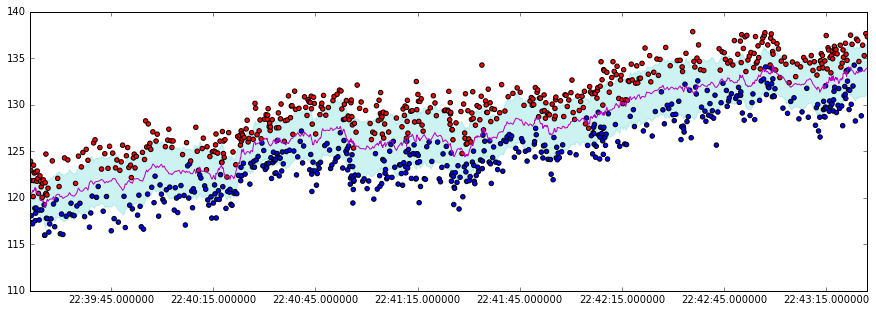

In [42]:
from itertools import izip, imap, islice
    
hist = list(islice(market(datetime.now()), 0, 1000))
_, pxs, spd     = zip(*hist)
ts, sides, ords, sizes = zip(*list(orders(hist)))

def _plot_orders(ords):
    %matplotlib inline

    import matplotlib.pyplot as plt

    ts, sides, ords, sizes = zip(*list(ords))
    plt.figure(figsize=(15, 5))

    plt.plot(ts, pxs, 'm')
    bids =  map(lambda (idx, px): px - spd[idx] / 2, enumerate(pxs))
    asks =  map(lambda (idx, px): px + spd[idx] / 2, enumerate(pxs))
    plt.fill_between(ts, bids, asks, color = 'c', alpha = 0.2)

    plt.scatter(ts, ords, c = map(lambda x: 'b' if x == 'buy' else 'r', sides))

    plt.axis([ts[0], ts[-1], None, None])
    plt.show()
    
_plot_orders(orders(hist))

In [43]:
###########################################################
#
# Order Book

def clear_order(order, size, book):
    (top_order, top_size, age), tail = book[0], book[1:]
    if order > top_order:
        if size < top_size:
            return [(top_order, top_size - size, age)] + tail
        else:
            return clear_order(order, size - top_size, tail)
        
def clear_book(book):
    while book['buy'] and book['sell']:
        order, size, _ = book['buy'][0]
        new_book = clear_order(order, size, book['sell'])
        if new_book:
            book['sell'] = new_book
            book['buy']  = book['buy'][1:]
        else:
            break
    return book

def _aged(book):
    for o, s, age in book:
        if age > 0:
            yield o, s, age - 1

def order_book(orders):
    book = {'buy': [], 'sell': []}
    for t, side, order, size in orders:
        old = list(_aged(book[side])) + [(order, size, 10)]
        book[side] = sorted(old, key = lambda x: -x[0] if side == 'buy' else x[0])
        yield copy(clear_book(book))

def top(books):
    for book in books:
        yield (book['buy'][0][0] if book['buy'] else 120), book['sell'][0][0] if book['sell'] else 120


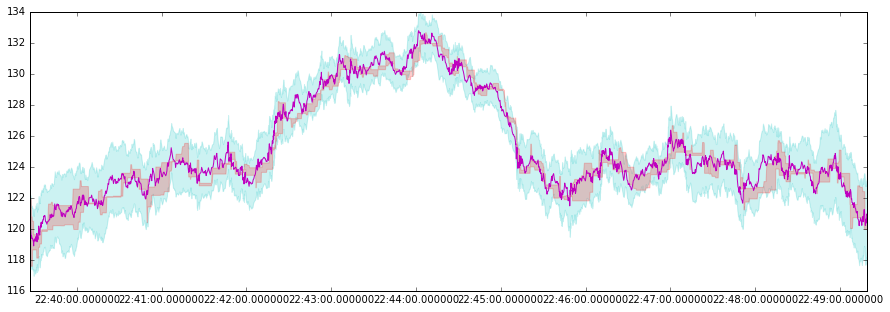

In [44]:
hist = list(islice(market(datetime.now()), 0, 2000))
_, pxs, spd     = zip(*hist)
ts, sides, ords, sizes = zip(*list(orders(hist)))

def _plot_orders(ords):
    %matplotlib inline

    import matplotlib.pyplot as plt
    ts, sides, ords, sizes = zip(*list(ords))
    ts = list(ts)
  
    books = list(order_book(zip(ts, sides, ords, sizes)))
    top_buy, top_sell = zip(*top(books))
    
    plt.figure(figsize=(15, 5))
    
    plt.plot(ts, pxs, 'm')
    bids =  map(lambda (idx, px): px - spd[idx] / 2, enumerate(pxs))
    asks =  map(lambda (idx, px): px + spd[idx] / 2, enumerate(pxs))
    plt.fill_between(ts, bids, asks, color = 'c', alpha = 0.2)

    #plt.scatter(ts, ords, c = map(lambda x: 'b' if x == 'buy' else 'r', sides))
    
    plt.fill_between(ts, top_buy, top_sell, color='r', alpha = 0.2)
 
    plt.axis([ts[0], ts[-1], None, None])
    plt.show()
    
_plot_orders(orders(hist))

In [91]:
def generate_csv():
    with open('test.csv', 'wb') as f:
        writer = csv.writer(f)
        for t, side, order, size in orders(market(MARKET_OPEN)):
            if t > MARKET_OPEN + SIM_LENGTH:
                break
            writer.writerow([t, side, order, size])
      
def read_csv():
    with open('test.csv', 'rb') as f:
        for time, side, order, size in csv.reader(f):
            yield dateutil.parser.parse(time), side, order, size

In [358]:
###########################################################
#
# Server

class ThreadedHTTPServer(ThreadingMixIn, HTTPServer):
    allow_reuse_address = True
    def shutdown(self):
        self.socket.close()
        HTTPServer.shutdown(self)

def _get(req_handler, routes):
    for name, handler in routes.__class__.__dict__.iteritems():
        if hasattr(handler, "__route__") and None != re.search(handler.__route__, req_handler.path):
            req_handler.send_response(200)
            req_handler.send_header('Content-Type', 'application/json')
            req_handler.end_headers()
            query = req_handler.path[len(handler.__route__):]
            data  = json.dumps(handler(routes, query))
            req_handler.wfile.write(data)
            return

def run(routes, host = '0.0.0.0', port = 8080):

    class RequestHandler(BaseHTTPRequestHandler):
        def log_message(self, *args, **kwargs):
            pass
        def do_GET(self):
            _get(self, routes)

    server = ThreadedHTTPServer((host, port), RequestHandler)
    thread = threading.Thread(target = server.serve_forever)
    thread.daemon = True
    thread.start()

    print 'HTTP server started on port 8080'

    thread.join()
    server.shutdown()
    server.start()
    server.waitForThread()

def route(path):
    def _route(f):
        setattr(f, '__route__', path)
        return f
    return _route

In [ ]:

###########################################################
#
# App

class App(object):

    def __init__(self):     
        self._start = datetime.datetime.now()
        self._data  = list(read_csv())
        self._bids, self._asks = [], []

    def _update_book(self, now):
        while self._data[0][0] < now:
            

    @route('/query/')
    def handle_query(self, x):
        now = datetime.datetime.now() - self._start
        print 'Query received @ t%s' % now
        
        prev  = self._data[0]
        start = prev[0]
        
        for row in self._data:
            if (row[0] - start) > now:
                break
            prev = row
        
        return {
            'bid': prev[1],
            'ask': prev[2]
        }

    @route('/sell/')
    def handle_sell(self, x):
        sell =  float(self.handle_query(None)['ask'])
        self._position -= float(x)
        self._pnl      += float(x) * sell

        print "Sold %s at $%s. Position: %s, PnL: %s" % (float(x), sell, self._position, self._pnl)

        return {
            'pnl':      self._pnl,
            'position': self._position
        }   


In [ ]:
###########################################################
#
# Main

if __name__ == '__main__':  
    if not os.path.isfile('test.csv'):
        generate_csv()
    run(App())


